C:\Users\yashw\PycharmProjects\PythonProject4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Precomputing tag & difficulty similarities ...


Tag Jaccard: 100%|██████████| 3706/3706 [06:10<00:00,  9.99it/s] 



=== Evaluation Results ===
       Variant  Precision@10  Recall@10  NDCG@10  Evaluated
Embedding-only        0.0469     0.2077   0.2292       3706
        Hybrid        0.0462     0.2048   0.2202       3706


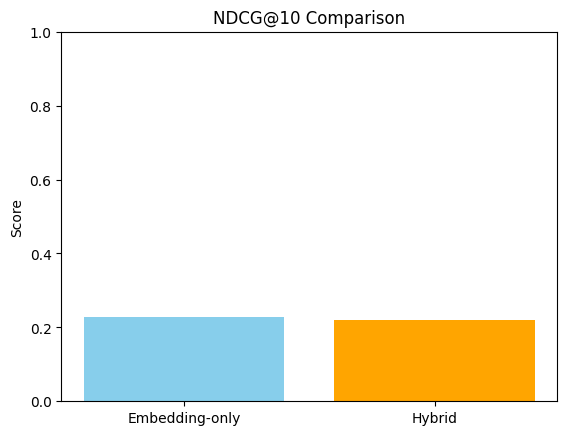

In [1]:
# ==================== FAST HYBRID RECOMMENDER (OPTIMIZED) ====================
import os, re, ast, math, pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------- 1️⃣ LOAD & CLEAN --------------------
df = pd.read_csv("../Data_Pipeline/preprocessed_data.csv")

def clean_title(text):
    text = str(text).lower().strip()
    text = re.sub(r'^\d+\.\s*', '', text)
    text = re.sub(r'[^a-z0-9\s\-]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def parse_similar(x):
    try:
        if isinstance(x, str):
            lst = ast.literal_eval(x)
            return [clean_title(i) for i in lst]
        return []
    except Exception:
        return []

df['clean_title'] = df['title'].apply(clean_title)
df['topic_tags']   = df['topic_tags'].fillna('').astype(str)
df['difficulty']   = df['difficulty'].fillna('').astype(str)
df['ground_truth'] = df['similar_questions'].apply(parse_similar)

def to_tag_list(s):
    if isinstance(s, str) and s.startswith('['):
        try:
            vals = ast.literal_eval(s)
            return [str(v).lower().strip() for v in vals]
        except Exception:
            pass
    return [t.strip().lower() for t in str(s).split(',') if t.strip()]

df['tag_list'] = df['topic_tags'].apply(to_tag_list)
df['combined_text'] = (
    df['clean_title'] + " | diff: " + df['difficulty'].str.lower() +
    " | tags: " + df['topic_tags'].str.lower()
)

# -------------------- 2️⃣ EMBEDDINGS (CACHED) --------------------
cache_path = Path("sbert_embeddings.pkl")
model_name = "all-MiniLM-L6-v2"

if cache_path.exists():
    with open(cache_path, "rb") as f:
        cache = pickle.load(f)
    if cache.get("model_name") == model_name and len(cache.get("embeddings", [])) == len(df):
        embeddings = cache["embeddings"]
    else:
        model = SentenceTransformer(model_name)
        embeddings = model.encode(df['combined_text'].tolist(), batch_size=64, show_progress_bar=True, normalize_embeddings=True)
        with open(cache_path, "wb") as f:
            pickle.dump({"model_name": model_name, "embeddings": embeddings}, f)
else:
    model = SentenceTransformer(model_name)
    embeddings = model.encode(df['combined_text'].tolist(), batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    with open(cache_path, "wb") as f:
        pickle.dump({"model_name": model_name, "embeddings": embeddings}, f)

embeddings = np.array(embeddings, dtype=np.float32)
N = len(df)

# -------------------- 3️⃣ PRECOMPUTE AUX MATRICES --------------------
print("Precomputing tag & difficulty similarities ...")
tag_sims = np.zeros((N, N), dtype=np.float32)
for i in tqdm(range(N), desc="Tag Jaccard"):
    tags_i = set(df.iloc[i]['tag_list'])
    if not tags_i: continue
    for j in range(i+1, N):
        tags_j = set(df.iloc[j]['tag_list'])
        if not tags_j: continue
        inter = len(tags_i & tags_j)
        uni   = len(tags_i | tags_j)
        if uni:
            val = inter / uni
            tag_sims[i,j] = tag_sims[j,i] = val

ladder = {"easy":0, "medium":1, "hard":2}
diff_vals = df['difficulty'].str.lower().map(ladder).fillna(1).to_numpy(dtype=np.int8)
diff_sims = np.ones((N, N), dtype=np.float32)
for i in range(N):
    for j in range(i+1, N):
        d = abs(diff_vals[i]-diff_vals[j])
        s = 1.0 if d==0 else 0.7 if d==1 else 0.4
        diff_sims[i,j] = diff_sims[j,i] = s

# -------------------- 4️⃣ POPULARITY SCORE --------------------
def minmax(x):
    x = x.fillna(0)
    rng = x.max() - x.min()
    return (x - x.min())/rng if rng != 0 else x*0
acc = minmax(df['acceptance']) if 'acceptance' in df else 0
likes = minmax(df['likes']) if 'likes' in df else 0
subs  = minmax(df['submission']) if 'submission' in df else 0
popularity_score = (0.3*acc + 0.5*likes + 0.2*subs).fillna(0).to_numpy(dtype=np.float32)

# -------------------- 5️⃣ HYBRID SCORING --------------------
def hybrid_scores(i, w_sim=0.70, w_tag=0.15, w_diff=0.10, w_pop=0.05, normalize=True):
    sims = embeddings @ embeddings[i]  # cosine (normalized)
    score = (
        w_sim  * sims +
        w_tag  * tag_sims[i] +
        w_diff * diff_sims[i] +
        w_pop  * popularity_score
    )
    if normalize:
        mn, mx = score.min(), score.max()
        if mx > mn: score = (score - mn)/(mx - mn)
    return score

def rank_by_scores(scores, k=10, exclude=None):
    if exclude is not None: scores[exclude] = -1e9
    idxs = np.argpartition(scores, -k)[-k:]
    idxs = idxs[np.argsort(scores[idxs])][::-1]
    return idxs

# -------------------- 6️⃣ RECOMMENDATION VARIANTS --------------------
def rec_embedding_only(i, k=10):
    sims = embeddings @ embeddings[i]
    return rank_by_scores(sims.copy(), k=k, exclude=i)

def rec_hybrid(i, k=10, w=(0.70,0.15,0.10,0.05)):
    s = hybrid_scores(i, *w)
    return rank_by_scores(s.copy(), k=k, exclude=i)

# -------------------- 7️⃣ METRICS --------------------
def precision_recall_at_k(pred, truth, k=10):
    if not truth: return None, None
    p = len(set(pred[:k]) & set(truth)) / k
    r = len(set(pred[:k]) & set(truth)) / len(truth)
    return p, r

def ndcg_at_k(pred, truth, k=10):
    rel = [1 if t in truth else 0 for t in pred[:k]]
    if not any(rel): return 0.0
    dcg  = sum(r/np.log2(i+2) for i, r in enumerate(rel))
    idcg = sum(sorted(rel, reverse=True)[i]/np.log2(i+2) for i in range(len(rel)))
    return dcg/idcg if idcg>0 else 0.0

def eval_variant(func, name, k=10, limit=None):
    P,R,N = [],[],[]
    n = len(df) if limit is None else min(limit, len(df))
    for i in range(n):
        gt = df.loc[i,'ground_truth']
        if not gt: continue
        idxs = func(i,k)
        preds = [df.iloc[j]['clean_title'] for j in idxs]
        p,r = precision_recall_at_k(preds, gt, k)
        n_  = ndcg_at_k(preds, gt, k)
        if p is not None: P.append(p); R.append(r); N.append(n_)
    return name, np.mean(P), np.mean(R), np.mean(N), len(P)

# -------------------- 8️⃣ EVALUATE --------------------
results = []
results.append(eval_variant(lambda i,k: rec_embedding_only(i,k), "Embedding-only", k=10))
results.append(eval_variant(lambda i,k: rec_hybrid(i,k,(0.70,0.15,0.10,0.05)), "Hybrid", k=10))

tbl = pd.DataFrame([{
    "Variant": name,
    "Precision@10": round(P,4),
    "Recall@10": round(R,4),
    "NDCG@10": round(N,4),
    "Evaluated": cnt
} for (name,P,R,N,cnt) in results])

print("\n=== Evaluation Results ===")
print(tbl.to_string(index=False))

plt.bar(tbl["Variant"], tbl["NDCG@10"], color=['skyblue','orange'])
plt.title("NDCG@10 Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()
# =======================================================================


In [2]:
# ==================== WEIGHT TUNING ====================
search_weights = [
    (0.80, 0.10, 0.05, 0.05),
    (0.75, 0.15, 0.05, 0.05),
    (0.70, 0.20, 0.05, 0.05),
    (0.65, 0.20, 0.10, 0.05),
    (0.60, 0.25, 0.10, 0.05),
    (0.70, 0.10, 0.15, 0.05),
    (0.70, 0.15, 0.10, 0.05),
    (0.80, 0.10, 0.10, 0.00)
]

results_tune = []
for w in search_weights:
    name, P,R,N,cnt = eval_variant(lambda i,k: rec_hybrid(i,k,w), f"Hybrid {w}", k=10, limit=None)
    results_tune.append((w,P,R,N))

tbl_tune = pd.DataFrame([{
    "Weights (sim, tag, diff, pop)": w,
    "Precision@10": round(P,4),
    "Recall@10": round(R,4),
    "NDCG@10": round(N,4)
} for (w,P,R,N) in results_tune]).sort_values(by="NDCG@10", ascending=False)

print("\n=== Weight Tuning Results (sorted by NDCG@10) ===")
print(tbl_tune.to_string(index=False))
best = tbl_tune.iloc[0]
print(f"\n✅ Best weight combination: {best['Weights (sim, tag, diff, pop)']} | NDCG@10={best['NDCG@10']}")



=== Weight Tuning Results (sorted by NDCG@10) ===
Weights (sim, tag, diff, pop)  Precision@10  Recall@10  NDCG@10
       (0.8, 0.1, 0.05, 0.05)        0.0481     0.2138   0.2306
         (0.8, 0.1, 0.1, 0.0)        0.0474     0.2092   0.2258
     (0.75, 0.15, 0.05, 0.05)        0.0472     0.2089   0.2238
       (0.7, 0.1, 0.15, 0.05)        0.0463     0.2041   0.2220
       (0.7, 0.15, 0.1, 0.05)        0.0462     0.2048   0.2202
       (0.7, 0.2, 0.05, 0.05)        0.0455     0.2016   0.2159
       (0.65, 0.2, 0.1, 0.05)        0.0448     0.1988   0.2118
       (0.6, 0.25, 0.1, 0.05)        0.0426     0.1872   0.2024

✅ Best weight combination: (0.8, 0.1, 0.05, 0.05) | NDCG@10=0.2306



=== Hybrid vs Hybrid+MMR ===
              Variant  Precision@10  Recall@10  NDCG@10  Evaluated
Hybrid (best weights)        0.0481     0.2138   0.2306       3706
    Hybrid+MMR λ=0.75        0.0488     0.2209   0.2344       3706


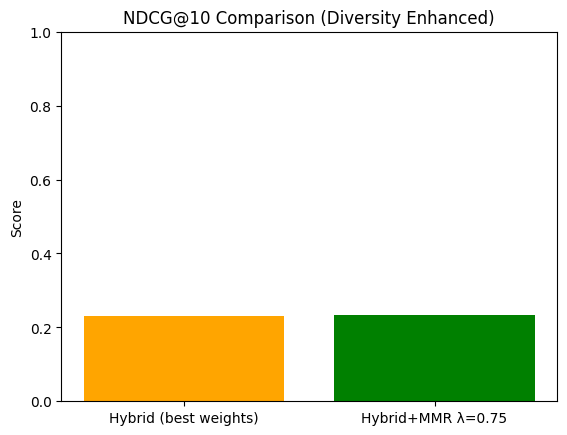

In [3]:
# ==================== HYBRID + MMR DIVERSITY EVALUATION ====================
from tqdm import tqdm
import numpy as np
import pandas as pd

# --- Use best weights discovered ---
best_w = (0.8, 0.1, 0.05, 0.05)
lambda_mmr = 0.75

def mmr_select(query_vec, cand_vecs, base_scores, k=10, lambda_=0.75):
    chosen = []
    cand_set = set(range(len(cand_vecs)))
    while len(chosen) < k and cand_set:
        best_i, best_val = None, -1e9
        for i in list(cand_set):
            rel = base_scores[i]
            div = 0.0
            if chosen:
                div = max(float(np.dot(cand_vecs[i], cand_vecs[j])) for j in chosen)
            val = lambda_*rel - (1 - lambda_)*div
            if val > best_val:
                best_val, best_i = val, i
        chosen.append(best_i)
        cand_set.remove(best_i)
    return chosen

def rec_hybrid_mmr(i, k=10, w=best_w, lambda_=lambda_mmr):
    base_score = hybrid_scores(i, *w)
    # top pool to diversify within
    pool = rank_by_scores(base_score.copy(), k=min(100, len(df)-1), exclude=i)
    cand_vecs = embeddings[pool]
    chosen_local = mmr_select(embeddings[i], cand_vecs, base_scores=base_score[pool], k=k, lambda_=lambda_)
    return pool[chosen_local]

# ---------- Evaluate ----------
results_mmr = []
results_mmr.append(eval_variant(lambda i,k: rec_hybrid(i,k,best_w), "Hybrid (best weights)", k=10))
results_mmr.append(eval_variant(lambda i,k: rec_hybrid_mmr(i,k,best_w,lambda_mmr), f"Hybrid+MMR λ={lambda_mmr}", k=10))

tbl_mmr = pd.DataFrame([{
    "Variant": name,
    "Precision@10": round(P,4),
    "Recall@10": round(R,4),
    "NDCG@10": round(N,4),
    "Evaluated": cnt
} for (name,P,R,N,cnt) in results_mmr])

print("\n=== Hybrid vs Hybrid+MMR ===")
print(tbl_mmr.to_string(index=False))

# Simple bar chart for clarity
import matplotlib.pyplot as plt
plt.bar(tbl_mmr["Variant"], tbl_mmr["NDCG@10"], color=["orange","green"])
plt.title("NDCG@10 Comparison (Diversity Enhanced)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()
# =======================================================================
